In [1]:
# 首先依赖导入包
!pip install seaborn
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# 这是用于进度条的
from tqdm import tqdm
import seaborn as sns

You are using pip version 9.0.1, however version 21.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# 看看label文件长啥样
import os
import moxing as mox


file_name = 'classify-leaves'
if not os.path.exists(file_name):
    mox.file.copy_parallel('obs://test444/input/classify-leaves/', 'classify-leaves/')
labels_dataframe = pd.read_csv('classify-leaves/train.csv')
labels_dataframe.head(5)

INFO:root:Using MoXing-v2.0.0.rc0-19e4d3ab
INFO:root:Using OBS-Python-SDK-3.20.9.1


,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [3]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/17614.jpg,maclura_pomifera
freq,1,353


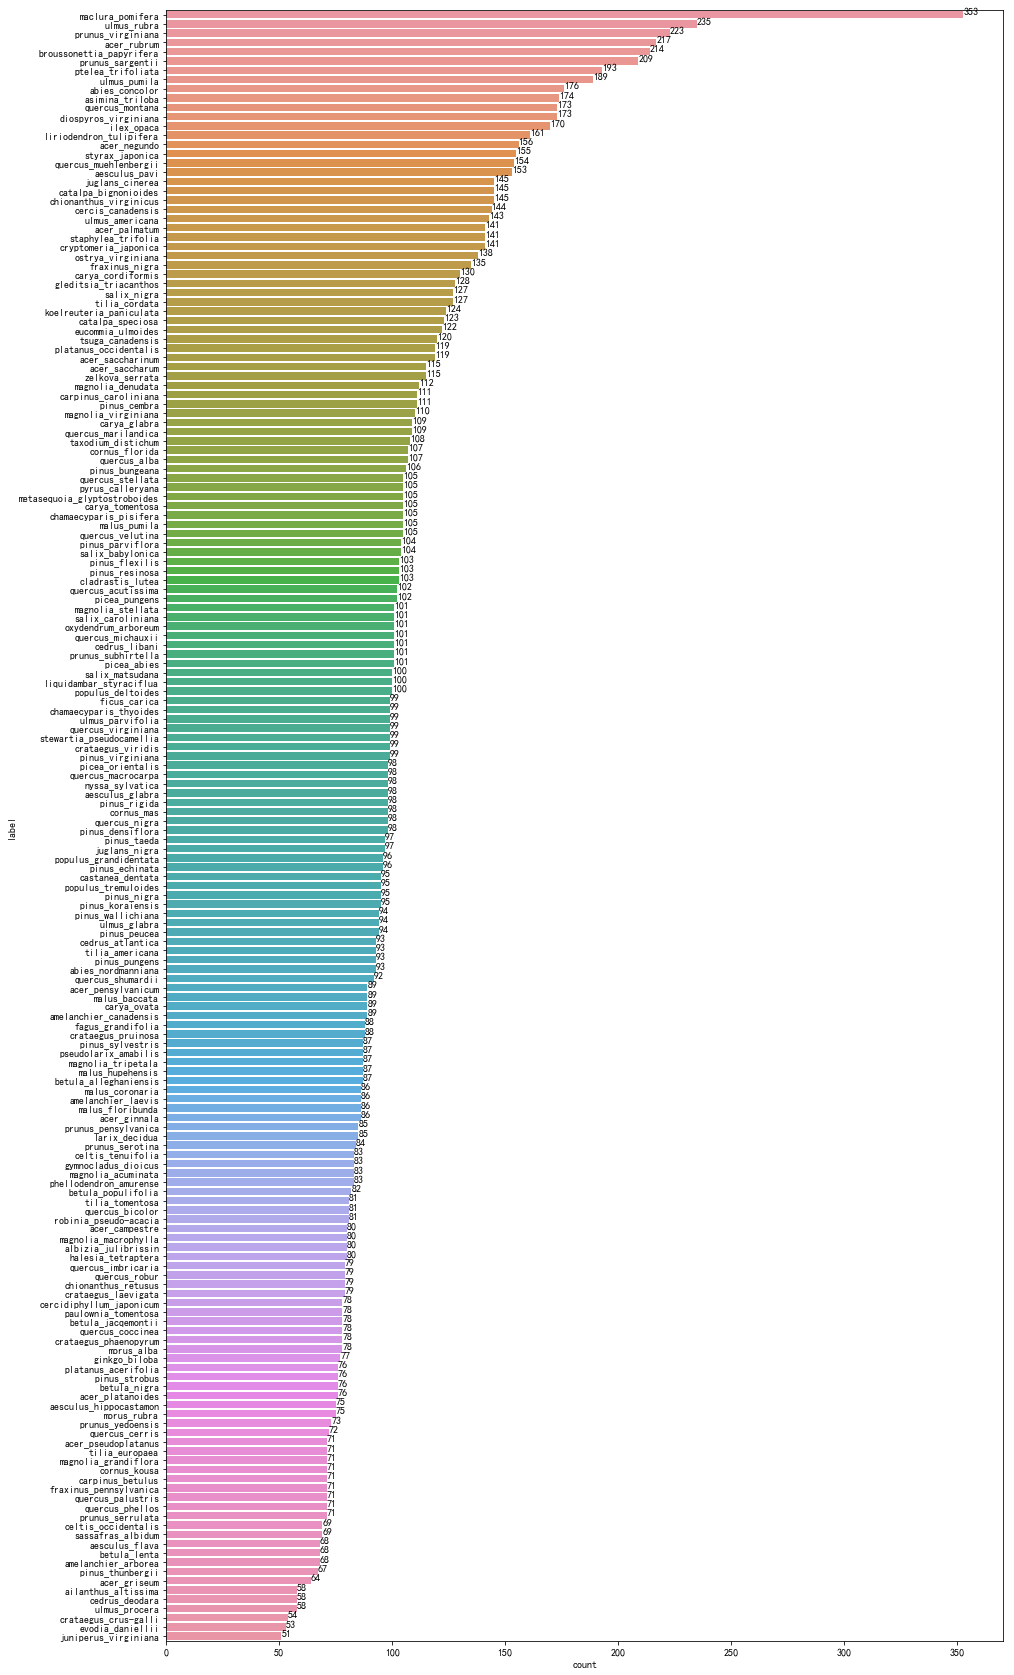

In [4]:
# 函数显示柱状长度

def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() # 长度
        x = p.get_x()+ p.get_width() # x轴位置 
        y = p.get_y() + p.get_height()/2 #y轴位置
        ax.annotate(round(val,2),(x,y))
        
# 找出出现最多的树叶类别
plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_dataframe['label'],order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()

In [5]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [6]:
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [7]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v : k for k, v in class_to_num.items()}

In [8]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len

In [9]:
train_path = 'classify-leaves/train.csv'
test_path = 'classify-leaves/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = 'classify-leaves/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [10]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=0
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=0
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=0
    )

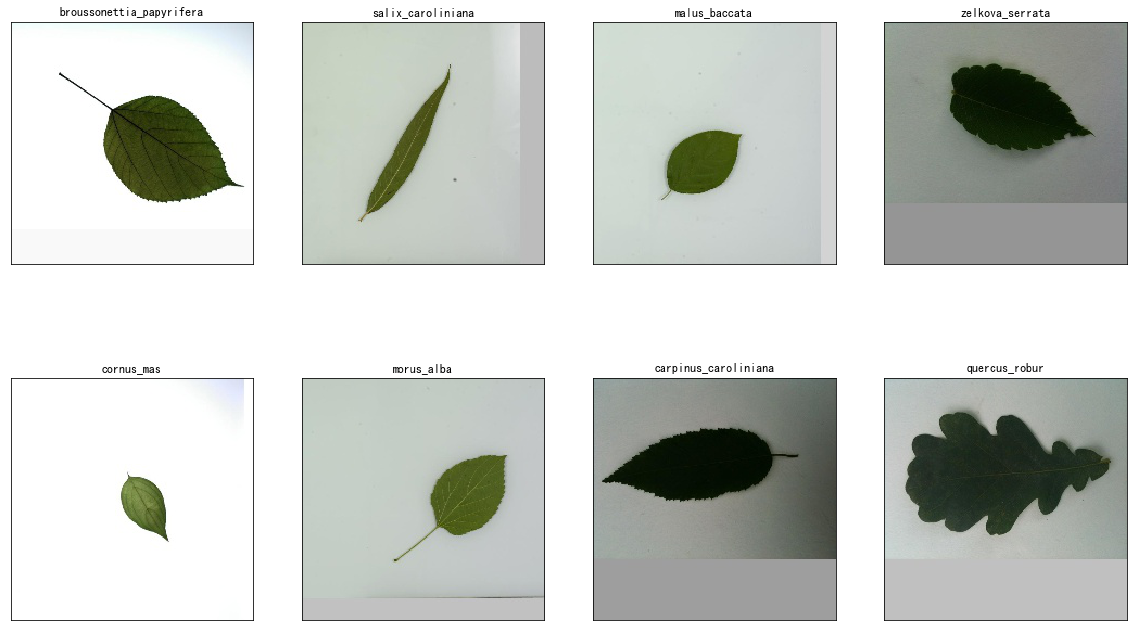

In [11]:
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [12]:
# 看一下是在cpu还是GPU上
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [13]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
            
# resnet34模型
def res_model(num_classes, feature_extract=False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [14]:
# 超参数
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 30
model_path = './pre_res_model.ckpt'

In [15]:
import os
import moxing as mox

mox.file.copy_parallel('obs://test444/resnet34-333f7ec4.pth', '/home/ma-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth')

In [16]:
# 初始化模型，并将其放在指定的设备上
model = res_model(176)
model = model.to(device)
model.device = device
# 对于分类任务，我们使用交叉熵作为性能的度量
criterion = nn.CrossEntropyLoss()

# 初始化优化器，您可以微调一些超参数，如学习速率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 训练的轮数
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- 训练模型 ----------
    # 训练前确保模型处于训练模式
    model.train() 
    # 这些是用来记录训练信息的
    train_loss = []
    train_accs = []
    # 分批迭代训练集
    for batch in tqdm(train_loader):
        # 批处理由图像数据和相应的标签组成
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # 提出了数据。(确保数据和模型在同一台设备上。)
        logits = model(imgs)
        # 计算交叉熵损失
        # 我们不需要在计算交叉熵之前应用softmax，因为它是自动完成的
        loss = criterion(logits, labels)
        
        # 应该首先清除存储在前一步参数中的梯度
        optimizer.zero_grad()
        # 计算参数的梯度
        loss.backward()
        # 使用计算的梯度更新参数
        optimizer.step()
        
        # 计算当前批处理的精度
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # 记录损失和准确性
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # 训练集的平均损失和准确率是记录值的平均值
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # 打印信息
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- 验证 ----------
    # 确保模型处于eval模式，以便某些模块如dropout被禁用并正常工作
    model.eval()
    # 它们用于在验证中记录信息
    valid_loss = []
    valid_accs = []
    
    # 按批迭代验证集
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # 在验证中我们不需要梯度
        # 使用torch.no_grad()加速前进过程
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # 我们仍然可以计算损失(但不是梯度)
        loss = criterion(logits, labels.to(device))

        # 计算当前批处理的精度
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # 记录损失和准确性
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # 整个验证集的平均损失和准确性是记录值的平均值
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # 打印信息
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # 如果模型得到改进，则在当前保存一个检查点
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

  1%|          | 4/459 [00:00<00:11, 39.01it/s]

[ Train | 001/030 ] loss = 2.89833, acc = 0.29119


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 001/030 ] loss = 1.77164, acc = 0.47440
saving model with acc 0.474


  1%|          | 5/459 [00:00<00:10, 41.63it/s]

[ Train | 002/030 ] loss = 1.64759, acc = 0.53152


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 002/030 ] loss = 1.47969, acc = 0.56618
saving model with acc 0.566


  1%|          | 5/459 [00:00<00:10, 44.24it/s]

[ Train | 003/030 ] loss = 1.26645, acc = 0.62881


  0%|          | 3/1836 [00:00<01:30, 20.32it/s]

[ Valid | 003/030 ] loss = 1.61899, acc = 0.53785


  1%|          | 5/459 [00:00<00:10, 41.97it/s]

[ Train | 004/030 ] loss = 1.03749, acc = 0.69002


100%|██████████| 459/459 [00:10<00:00, 44.69it/s]


[ Valid | 004/030 ] loss = 1.26572, acc = 0.63126


  0%|          | 2/1836 [00:00<01:33, 19.69it/s]

saving model with acc 0.631


  1%|          | 5/459 [00:00<00:09, 46.12it/s]

[ Train | 005/030 ] loss = 0.86805, acc = 0.74299


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 005/030 ] loss = 1.20156, acc = 0.64978
saving model with acc 0.650


  1%|          | 5/459 [00:00<00:09, 49.14it/s]

[ Train | 006/030 ] loss = 0.76289, acc = 0.77805


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 006/030 ] loss = 1.00259, acc = 0.70153
saving model with acc 0.702


  1%|          | 5/459 [00:00<00:10, 42.59it/s]

[ Train | 007/030 ] loss = 0.67211, acc = 0.80487


100%|██████████| 459/459 [00:09<00:00, 47.08it/s]


[ Valid | 007/030 ] loss = 0.93371, acc = 0.71814


  0%|          | 2/1836 [00:00<01:33, 19.60it/s]

saving model with acc 0.718


  1%|          | 5/459 [00:00<00:09, 46.46it/s]

[ Train | 008/030 ] loss = 0.60694, acc = 0.82850


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 008/030 ] loss = 0.91117, acc = 0.73339
saving model with acc 0.733


  1%|          | 5/459 [00:00<00:09, 45.42it/s]

[ Train | 009/030 ] loss = 0.55278, acc = 0.84266


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 009/030 ] loss = 0.89473, acc = 0.73666
saving model with acc 0.737


  1%|          | 5/459 [00:00<00:09, 47.79it/s]

[ Train | 010/030 ] loss = 0.50926, acc = 0.85798


  0%|          | 3/1836 [00:00<01:28, 20.70it/s]

[ Valid | 010/030 ] loss = 0.98803, acc = 0.72495


  1%|          | 5/459 [00:00<00:09, 45.87it/s]

[ Train | 011/030 ] loss = 0.47525, acc = 0.86751


100%|██████████| 459/459 [00:10<00:00, 44.88it/s]


[ Valid | 011/030 ] loss = 0.86573, acc = 0.74510


  0%|          | 2/1836 [00:00<01:35, 19.21it/s]

saving model with acc 0.745


  1%|          | 5/459 [00:00<00:11, 40.36it/s]

[ Train | 012/030 ] loss = 0.43966, acc = 0.88024


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 012/030 ] loss = 0.83703, acc = 0.76498
saving model with acc 0.765


  1%|          | 5/459 [00:00<00:09, 45.88it/s]

[ Train | 013/030 ] loss = 0.41725, acc = 0.88875


  0%|          | 2/1836 [00:00<01:36, 19.01it/s]

[ Valid | 013/030 ] loss = 0.85248, acc = 0.74700


  1%|          | 5/459 [00:00<00:11, 40.00it/s]

[ Train | 014/030 ] loss = 0.40067, acc = 0.89100


  0%|          | 2/1836 [00:00<01:31, 19.95it/s]

[ Valid | 014/030 ] loss = 0.84934, acc = 0.76117


  1%|          | 4/459 [00:00<00:11, 39.58it/s]

[ Train | 015/030 ] loss = 0.37671, acc = 0.90080


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 015/030 ] loss = 0.74336, acc = 0.78404
saving model with acc 0.784


  1%|          | 4/459 [00:00<00:11, 39.96it/s]

[ Train | 016/030 ] loss = 0.35156, acc = 0.91081


  0%|          | 2/1836 [00:00<01:37, 18.80it/s]

[ Valid | 016/030 ] loss = 0.82855, acc = 0.77206


  1%|          | 5/459 [00:00<00:09, 46.26it/s]

[ Train | 017/030 ] loss = 0.35358, acc = 0.90843


  0%|          | 2/1836 [00:00<01:49, 16.75it/s]

[ Valid | 017/030 ] loss = 0.86511, acc = 0.75109


  1%|          | 5/459 [00:00<00:11, 40.31it/s]

[ Train | 018/030 ] loss = 0.34152, acc = 0.91006


  0%|          | 3/1836 [00:00<01:29, 20.52it/s]

[ Valid | 018/030 ] loss = 0.90451, acc = 0.74946


  1%|          | 5/459 [00:00<00:09, 46.72it/s]

[ Train | 019/030 ] loss = 0.33354, acc = 0.91367


  0%|          | 2/1836 [00:00<01:35, 19.14it/s]

[ Valid | 019/030 ] loss = 0.75124, acc = 0.78077


  1%|          | 5/459 [00:00<00:10, 41.52it/s]

[ Train | 020/030 ] loss = 0.31148, acc = 0.92531


  0%|          | 2/1836 [00:00<01:37, 18.76it/s]

[ Valid | 020/030 ] loss = 0.99248, acc = 0.72086


  1%|          | 5/459 [00:00<00:10, 44.92it/s]

[ Train | 021/030 ] loss = 0.31034, acc = 0.92361


  0%|          | 2/1836 [00:00<01:36, 18.94it/s]

[ Valid | 021/030 ] loss = 0.76957, acc = 0.78077


  1%|          | 5/459 [00:00<00:09, 45.48it/s]

[ Train | 022/030 ] loss = 0.29815, acc = 0.92640


100%|██████████| 459/459 [00:10<00:00, 45.36it/s]


[ Valid | 022/030 ] loss = 0.74225, acc = 0.78704


  0%|          | 2/1836 [00:00<01:39, 18.49it/s]

saving model with acc 0.787


  1%|          | 5/459 [00:00<00:11, 40.75it/s]

[ Train | 023/030 ] loss = 0.28533, acc = 0.93137


  0%|          | 3/1836 [00:00<01:28, 20.62it/s]

[ Valid | 023/030 ] loss = 0.75302, acc = 0.77941


  1%|          | 5/459 [00:00<00:09, 47.79it/s]

[ Train | 024/030 ] loss = 0.28621, acc = 0.93151


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 024/030 ] loss = 0.72515, acc = 0.79357
saving model with acc 0.794


  1%|          | 5/459 [00:00<00:10, 42.26it/s]

[ Train | 025/030 ] loss = 0.27675, acc = 0.93246


  0%|          | 2/1836 [00:00<01:33, 19.59it/s]

[ Valid | 025/030 ] loss = 0.76590, acc = 0.78595


  1%|          | 5/459 [00:00<00:10, 43.56it/s]

[ Train | 026/030 ] loss = 0.26794, acc = 0.93723


  0%|          | 2/1836 [00:00<01:36, 19.07it/s]

[ Valid | 026/030 ] loss = 0.75907, acc = 0.78867


  1%|          | 5/459 [00:00<00:09, 47.58it/s]

[ Train | 027/030 ] loss = 0.27054, acc = 0.93505


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 027/030 ] loss = 0.71540, acc = 0.79929
saving model with acc 0.799


  1%|          | 5/459 [00:00<00:09, 47.02it/s]

[ Train | 028/030 ] loss = 0.26198, acc = 0.93804


  0%|          | 2/1836 [00:00<01:42, 17.83it/s]

[ Valid | 028/030 ] loss = 0.83970, acc = 0.77369


  1%|          | 5/459 [00:00<00:09, 49.26it/s]

[ Train | 029/030 ] loss = 0.25608, acc = 0.93981


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 029/030 ] loss = 0.65332, acc = 0.80910
saving model with acc 0.809


  1%|          | 4/459 [00:00<00:12, 37.33it/s]

[ Train | 030/030 ] loss = 0.25401, acc = 0.94281


100%|██████████| 459/459 [00:09<00:00, 45.91it/s]

[ Valid | 030/030 ] loss = 1.25681, acc = 0.66149


In [17]:
saveFileName = './submission.csv'

In [18]:
## 预测
model = res_model(176)

# 从检查点创建模型和负载权重
model = model.to(device)
model.load_state_dict(torch.load(model_path))

# 确保模型处于eval模式
# 有些模块如Dropout或BatchNorm会影响模型是否处于训练模式
model.eval()

# 初始化一个列表以存储预测
predictions = []
# 逐批迭代测试集
for batch in tqdm(test_loader):
    
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # 用最好的日志作为预测，并记录下来
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")

100%|██████████| 1100/1100 [00:29<00:00, 37.04it/s]


Done!!!!!!!!!!!!!!!!!!!!!!!!!!!
